RandomForest

✅ Features : 7 colonnes
✅ Samples  : 105,829 lignes

📊 Distribution Target :
   Train : {1: 0.5396690407852308, 0: 0.46033095921476913}
   Test  : {1: 0.5349144854956062, 0: 0.46508551450439384}

🚀 Entraînement en cours...

📊 RÉSULTATS SUR LE TEST SET
Accuracy  : 50.51%
Precision : 53.82%
Recall    : 52.64%
F1-Score  : 53.22%
ROC-AUC   : 50.98%

📝 RAPPORT DÉTAILLÉ :
              precision    recall  f1-score   support

      Baisse       0.47      0.48      0.47      9844
      Hausse       0.54      0.53      0.53     11322

    accuracy                           0.51     21166
   macro avg       0.50      0.50      0.50     21166
weighted avg       0.51      0.51      0.51     21166



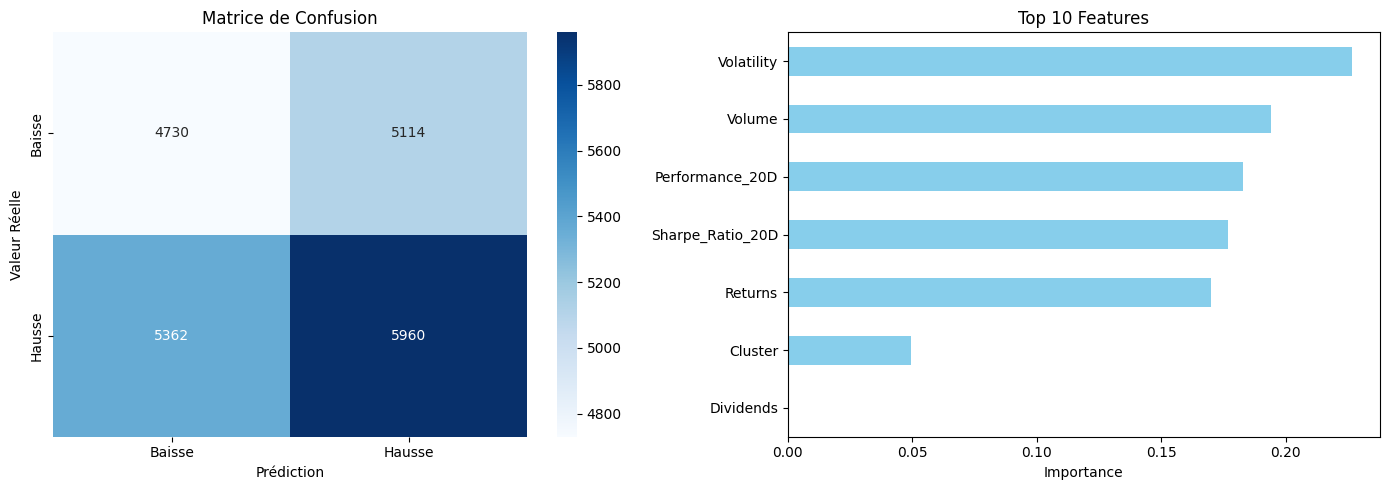


⚠️ Taux d'erreur global : 49.49%

📊 Taux d'erreur par Cluster :
Cluster
 3    0.519300
 2    0.502530
 1    0.491821
 0    0.484141
-1    0.448833
Name: Error, dtype: float64

✅ Modèle sauvegardé : /home/onyxia/work/Gestion-portefeuille/models/random_forest_final.pkl
✅ Liste des features sauvegardée


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             precision_score, recall_score, f1_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

# --- 1. CONFIGURATION ---
PROJECT_ROOT = Path("/home/onyxia/work/Gestion-portefeuille/")
PATH_SUPERSET = PROJECT_ROOT / "data/processed/cac40_final_superset.csv"
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)

# --- 2. CHARGEMENT ---
df = pd.read_csv(PATH_SUPERSET, parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# --- 3. PRÉPARATION X, y ---
potential_drops = ['Date', 'Ticker', 'Target', 'Target_Next_5D', 'Target_Price', 'Close']
cols_to_drop = [c for c in potential_drops if c in df.columns]

X = df.drop(columns=cols_to_drop)
y = df['Target']

print(f"✅ Features : {X.shape[1]} colonnes")
print(f"✅ Samples  : {len(X):,} lignes")

# --- 4. SPLIT TEMPOREL ---
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Vérification de l'équilibre
print(f"\n📊 Distribution Target :")
print(f"   Train : {y_train.value_counts(normalize=True).to_dict()}")
print(f"   Test  : {y_test.value_counts(normalize=True).to_dict()}")

# --- 5. OPTIMISATION DES HYPERPARAMÈTRES (optionnel mais recommandé) ---
USE_GRID_SEARCH = False  # Mettre True pour optimiser (plus long)

if USE_GRID_SEARCH:
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 15],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced', None]
    }
    
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid, cv=tscv, scoring='f1', verbose=1, n_jobs=-1
    )
    grid.fit(X_train, y_train)
    model = grid.best_estimator_
    print(f"\n✅ Meilleurs params : {grid.best_params_}")
else:
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',  # ✅ Gère le déséquilibre
        random_state=42,
        n_jobs=-1
    )
    print("\n🚀 Entraînement en cours...")
    model.fit(X_train, y_train)

# --- 6. ÉVALUATION ---
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("📊 RÉSULTATS SUR LE TEST SET")
print("="*50)
print(f"Accuracy  : {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision : {precision_score(y_test, y_pred):.2%}")
print(f"Recall    : {recall_score(y_test, y_pred):.2%}")
print(f"F1-Score  : {f1_score(y_test, y_pred):.2%}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_pred_proba):.2%}")

print("\n📝 RAPPORT DÉTAILLÉ :")
print(classification_report(y_test, y_pred, target_names=['Baisse', 'Hausse']))

# --- 7. MATRICE DE CONFUSION ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Baisse', 'Hausse'], yticklabels=['Baisse', 'Hausse'])
axes[0].set_title('Matrice de Confusion')
axes[0].set_ylabel('Valeur Réelle')
axes[0].set_xlabel('Prédiction')

# --- 8. IMPORTANCE DES FEATURES ---
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)
importances.tail(10).plot(kind='barh', color='skyblue', ax=axes[1])
axes[1].set_title("Top 10 Features")
axes[1].set_xlabel("Importance")

plt.tight_layout()
plt.savefig(MODEL_DIR / "evaluation_report.png", dpi=150)
plt.show()

# --- 9. ANALYSE DES ERREURS ---
errors_df = pd.DataFrame({
    'True': y_test.values,
    'Pred': y_pred,
    'Proba': y_pred_proba,
    'Cluster': X_test['Cluster'].values if 'Cluster' in X.columns else -1
})
errors_df['Error'] = errors_df['True'] != errors_df['Pred']

print(f"\n⚠️ Taux d'erreur global : {errors_df['Error'].mean():.2%}")

if 'Cluster' in X.columns:
    error_by_cluster = errors_df.groupby('Cluster')['Error'].mean().sort_values(ascending=False)
    print(f"\n📊 Taux d'erreur par Cluster :")
    print(error_by_cluster)

# --- 10. SAUVEGARDE ---
model_path = MODEL_DIR / "random_forest_final.pkl"
joblib.dump(model, model_path)
print(f"\n✅ Modèle sauvegardé : {model_path}")

# Sauvegarder les features utilisées
feature_list = X.columns.tolist()
with open(MODEL_DIR / "features.txt", 'w') as f:
    f.write('\n'.join(feature_list))
print(f"✅ Liste des features sauvegardée")

XGboost

In [3]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# 1. Préparation des données spécifique à XGBoost
# XGBoost préfère les types de données simples
print("Entraînement de XGBoost en cours...")

model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 2. Entraînement
model_xgb.fit(X_train, y_train)

# 3. Prédiction et Score
y_pred_xgb = model_xgb.predict(X_test)
print(f"🎯 Accuracy XGBoost : {accuracy_score(y_test, y_pred_xgb):.2%}")
print("\n📝 Rapport XGBoost :")
print(classification_report(y_test, y_pred_xgb))

Entraînement de XGBoost en cours...
🎯 Accuracy XGBoost : 53.31%

📝 Rapport XGBoost :
              precision    recall  f1-score   support

           0       0.49      0.17      0.26      9844
           1       0.54      0.85      0.66     11322

    accuracy                           0.53     21166
   macro avg       0.52      0.51      0.46     21166
weighted avg       0.52      0.53      0.47     21166



/opt/python/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:15:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


LSTM

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pathlib import Path

# 1. Préparation des données (on utilise une fenêtre de 10 jours)
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# 2. Chargement et Normalisation (Crucial pour le Deep Learning)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # X vient de tes cellules précédentes
X_df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Création des séquences 3D
TIME_STEPS = 10
X_3d, y_3d = create_sequences(X_df_scaled, y, TIME_STEPS)

# Split temporel
split = int(len(X_3d) * 0.8)
X_train_lstm, X_test_lstm = X_3d[:split], X_3d[split:]
y_train_lstm, y_test_lstm = y_3d[:split], y_3d[split:]

# 3. Architecture du modèle LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid') # Sigmoid pour une classification binaire (0 ou 1)
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Entraînement
print("🧠 Entraînement du LSTM en cours...")
history = model_lstm.fit(
    X_train_lstm, y_train_lstm, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.1,
    verbose=1
)

# 5. Évaluation
loss, acc = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print(f"🎯 Accuracy LSTM : {acc:.2%}")

🧠 Entraînement du LSTM en cours...
Epoch 1/10


/opt/python/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2381/2381 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.4579 - loss: nan - val_accuracy: 0.4829 - val_loss: nan
Epoch 2/10
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.4579 - loss: nan - val_accuracy: 0.4829 - val_loss: nan
Epoch 3/10
2336/2381 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4598 - loss: nan

KeyboardInterrupt: 

SVM

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
import joblib
from pathlib import Path
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Force TensorFlow à ignorer le GPU absent

# --- CONFIGURATION ---
PROJECT_ROOT = Path("/home/onyxia/work/Gestion-portefeuille/")
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)

# --- CHARGEMENT (depuis votre code précédent) ---
# Supposons que X, y, X_train, X_test, y_train, y_test sont déjà définis

# --- 1. CALCUL DU DÉSÉQUILIBRE ---
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"📊 Scale pos weight : {scale_pos_weight:.2f}")

# --- 2. XGBOOST ---
print("\n🚀 Entraînement XGBoost...")
model_xgb = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    early_stopping_rounds=50,
    random_state=42
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_pred_xgb = model_xgb.predict(X_test)
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

print(f"✅ XGBoost Accuracy : {accuracy_score(y_test, y_pred_xgb):.2%}")
print(f"✅ XGBoost ROC-AUC  : {roc_auc_score(y_test, y_proba_xgb):.2%}")

# --- 3. SVM (sur échantillon si trop lent) ---
print("\n🚀 Entraînement SVM...")

# Si dataset trop grand, réduire pour SVM
MAX_SAMPLES_SVM = 10000
if len(X_train) > MAX_SAMPLES_SVM:
    sample_idx = np.random.choice(len(X_train), MAX_SAMPLES_SVM, replace=False)
    X_train_svm = X_train.iloc[sample_idx]
    y_train_svm = y_train.iloc[sample_idx]
    print(f"⚠️ SVM entraîné sur {MAX_SAMPLES_SVM} samples (trop lent sinon)")
else:
    X_train_svm = X_train
    y_train_svm = y_train

scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train_svm)
X_test_svm_scaled = scaler_svm.transform(X_test)

model_svm = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42,
    cache_size=1000
)

model_svm.fit(X_train_svm_scaled, y_train_svm)
y_pred_svm = model_svm.predict(X_test_svm_scaled)
y_proba_svm = model_svm.predict_proba(X_test_svm_scaled)[:, 1]

print(f"✅ SVM Accuracy : {accuracy_score(y_test, y_pred_svm):.2%}")
print(f"✅ SVM ROC-AUC  : {roc_auc_score(y_test, y_proba_svm):.2%}")

# --- 4. LSTM (avec séquences groupées) ---
print("\n🚀 Préparation LSTM...")

# Fonction de création de séquences (version simplifiée sans ticker)
# IMPORTANT : Dans votre cas réel, utilisez la version avec grouping par Ticker
def create_sequences(X, y, time_steps=20):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Normalisation
scaler_lstm = StandardScaler()
X_train_lstm_scaled = scaler_lstm.fit_transform(X_train)
X_test_lstm_scaled = scaler_lstm.transform(X_test)

TIME_STEPS = 20
X_train_lstm, y_train_lstm = create_sequences(X_train_lstm_scaled, y_train.values, TIME_STEPS)
X_test_lstm, y_test_lstm = create_sequences(X_test_lstm_scaled, y_test.values, TIME_STEPS)

print(f"✅ LSTM Train shape : {X_train_lstm.shape}")

model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(TIME_STEPS, X_train_lstm.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=30,
    batch_size=64,
    validation_split=0.15,
    callbacks=[early_stop],
    verbose=0
)

y_pred_lstm_proba = model_lstm.predict(X_test_lstm).flatten()
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

print(f"✅ LSTM Accuracy : {accuracy_score(y_test_lstm, y_pred_lstm):.2%}")
print(f"✅ LSTM ROC-AUC  : {roc_auc_score(y_test_lstm, y_pred_lstm_proba):.2%}")

# --- 5. ENSEMBLE (VOTING) ---
print("\n🚀 Création de l'ensemble...")

# Alignement des prédictions (LSTM a moins de samples à cause des séquences)
# On prend uniquement les indices communs
common_indices = X_test.index[-len(y_pred_lstm):]

y_test_aligned = y_test.loc[common_indices]
y_pred_xgb_aligned = model_xgb.predict(X_test.loc[common_indices])
y_pred_svm_aligned = model_svm.predict(scaler_svm.transform(X_test.loc[common_indices]))

# Vote majoritaire
ensemble_pred = np.round((y_pred_xgb_aligned + y_pred_svm_aligned + y_pred_lstm) / 3)

print(f"✅ Ensemble Accuracy : {accuracy_score(y_test_aligned, ensemble_pred):.2%}")

# --- 6. COMPARAISON FINALE ---
results = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'LSTM', 'Ensemble'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test_lstm, y_pred_lstm),
        accuracy_score(y_test_aligned, ensemble_pred)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_xgb),
        roc_auc_score(y_test, y_proba_svm),
        roc_auc_score(y_test_lstm, y_pred_lstm_proba),
        np.nan  # Pas de proba pour le vote simple
    ]
})

print("\n" + "="*50)
print("📊 COMPARAISON DES MODÈLES")
print("="*50)
print(results.to_string(index=False))

# --- 7. SAUVEGARDE ---
joblib.dump(model_xgb, MODEL_DIR / "xgboost_model.pkl")
joblib.dump(model_svm, MODEL_DIR / "svm_model.pkl")
joblib.dump(scaler_svm, MODEL_DIR / "scaler_svm.pkl")
model_lstm.save(MODEL_DIR / "lstm_model.h5")
joblib.dump(scaler_lstm, MODEL_DIR / "scaler_lstm.pkl")

print("\n✅ Tous les modèles ont été sauvegardés")

📊 Scale pos weight : 0.85

🚀 Entraînement XGBoost...
✅ XGBoost Accuracy : 50.62%
✅ XGBoost ROC-AUC  : 51.52%

🚀 Entraînement SVM...
⚠️ SVM entraîné sur 10000 samples (trop lent sinon)
✅ SVM Accuracy : 51.03%
✅ SVM ROC-AUC  : 50.37%

🚀 Préparation LSTM...
✅ LSTM Train shape : (84643, 20, 7)


/opt/python/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


661/661 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step
✅ LSTM Accuracy : 53.38%
✅ LSTM ROC-AUC  : 51.96%

🚀 Création de l'ensemble...


✅ Ensemble Accuracy : 51.54%

📊 COMPARAISON DES MODÈLES
   Model  Accuracy  ROC-AUC
 XGBoost  0.506236 0.515224
     SVM  0.510300 0.503699
    LSTM  0.533765 0.519601
Ensemble  0.515369      NaN

✅ Tous les modèles ont été sauvegardés
